## Creating original computer-generated music inspired by Bach's chorales

In this notebook, we create a model that will be able to generate original music after being trained on a large corpus comprised of J.S. Bach's chorale pieces.   

Some high-level features of this work: 
* This project is inspired by an exercise proposed in chapter 15 of the _Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow_ book. You can check out the author's implementation in [this notebook](https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb)      
* The model is based on an architecture consisting of stacked Gated Recurrent Units followed by a dense layer, regularized with droupout, and stabilized with layer normalization,          
* Training is performed in a many-to-many scheme: at each step, the model tries to predict the next note (as opposed to a many-to-one scheme, where the model would be exposed to a sequence of notes and try to predict the last one)   
* The dataset is available at [this link](https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/jsb_chorales/jsb_chorales.tgz) and contains _.csv_ files for each of the pieces    
* The dataset is split into train (229 pieces), validation (76 pieces) and test (77 pieces) partitions (yes, Bach was a tremendous workaholic!)   
* Each sample in the _.csv_ files contains 4 integer values ranging from 36 to 81 corresponding to 4 notes (one for each of the four voices) that are sung simultaneously, with an uniform note duration of half a beat      
* In order to train the model, each note is converted to a one-hot encoding to represent each of the possible notes, plus 0 for silence and -1 to indicate the end of a piece
* The dataset is augmented so that, before each training epoch, each of the pieces is randomly transposed by a number of steps in the range of -5 to 6 - this ensures that the model is equally exposed to musical patterns in all different keys   
* After training, the model is used to generate new music one note at a time by choosing each note randomly according to the probabilities generated by the softmax layer of the neural network      
* The original music is saved to midi files using the _mido_ package

### Importing packages

Besides the usual suspects, we also import the _mido_ package for creating and saving the _.mid_ files, as well as some functions from _os_ and _os.path_ to manipulate files and directories.   

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from os import getcwd, listdir, mkdir
from os.path import join
import mido
import time

### Dataset preparation   

The dataset is downloaded from [this link](https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/jsb_chorales/jsb_chorales.tgz)

In [2]:
#### download/unzip dataset

Some helper functions are required to encode the music using one-hot encoding and decode the results from the softmax layer. Another helper function is defined to transpose an entire piece by a selected number of half steps.

In [3]:
# 81+6 and 36-5 due to transposing randomly between -5 half-steps and +6 half-steps

def one_hot_encoding(note):
    vector = np.zeros(((81+6)-(36-5)+3))
    if note == -1: # eof
        vector[0] = 1
    elif note == 0: # silence
        vector[1] = 1
    elif note >= (36-5) and note <= (81+6):
        vector[note-(36-5)+2] = 1
    else:
        raise Exception('invalid note, should be either -1 (eof), 0 (silence), or [36-5,81+6]; received {}'.format(note))
    return vector

def one_hot_decoding(vector):
    if vector.flatten()[0] == 1: # eof
        note = -1
    elif vector.flatten()[1] == 1: # silence
        note = 0
    else:
        note = vector.flatten().argmax() + (36-5) - 2
    return note

def transpose_note(note, interval):
    if note >= (36-5) and note <= (81+6):
        transposed = note + interval
    else:
        transposed = note
    return transposed

Next, some functions are defined to systematically prepared the train, valid and test datasets using tensorflow's data API.   

The make_dataset() function calls load_partition() to create a dataset consisting of a list of the files in each partition. This function then zips together each file and a randomly selected number of steps by which the piece will be transposed.   

Since the number of steps is randomly generated via a generator function, this quantity will be different for each piece and will be resampled at each epoch. This ensures that the model will be trained with each of the pieces transposed to several different keys, ensuring variability and improving generalization.   

After that, the parse_csv() function is called on each of the dataset entries (at this point, a file and a number of steps to transpose it by) via the flat_map() method. The parse_csv() function reads the _.csv_ file associated with one piece, decodes it, transposes all the notes and adds four end-of-file identifiers (-1).   

In [4]:
def generator_random_transpose():
    yield tf.random.Generator.from_non_deterministic_state().uniform(shape=[], minval=-5, maxval=6+1, dtype=tf.dtypes.int32).numpy()    

def parse_csv(file, interval): # added interval argument
    dataset_parsed = tf.data.TextLineDataset(file).skip(1)
    defaults = [0]*4
    dataset_parsed = dataset_parsed.map(lambda line: tf.stack(tf.io.decode_csv(line, defaults)))
    
    dataset_parsed = dataset_parsed.unbatch()    
    dataset_interval = tf.data.Dataset.from_tensor_slices([interval]).repeat()
    dataset_parsed = tf.data.Dataset.zip((dataset_parsed, dataset_interval))
    dataset_transposed = dataset_parsed.map(transpose_note)
    
    eof = tf.data.Dataset.from_tensor_slices([-1,-1,-1,-1])
    dataset_transposed = dataset_transposed.concatenate(eof)
    
    return dataset_transposed

def load_partition(partition='train'):
    filename = listdir(join(getcwd(), 'bach-chorales', partition))
    files = []
    for file in filename:
        files.append(join(getcwd(), 'bach-chorales', partition, file))
    dataset = tf.data.Dataset.list_files(files)
    
    dataset_random_transpose = tf.data.Dataset.from_generator(generator_random_transpose, output_types=tf.dtypes.int32)
    num_pieces = dataset.cardinality().numpy()
    dataset = tf.data.Dataset.zip((dataset, dataset_random_transpose.repeat(num_pieces)))
    
    dataset = dataset.flat_map(parse_csv) # flat_map ~ simple interleave
    return dataset

def make_dataset(partition='train'):
    dataset = list(load_partition(partition).repeat(12).as_numpy_iterator())
    x = dataset[:-1]
    y = dataset[1:]
    x_encoded = [one_hot_encoding(note) for note in x]
    y_encoded = [one_hot_encoding(note) for note in y]
    dataset = tf.data.Dataset.from_tensor_slices((x_encoded, y_encoded))
    return dataset

The make_dataset() function is called to prepare the train, valid and test sets. At this point, each dataset is composed of a sequence of single notes represented via a one-hot encoding. Splitting each into a number of different sequences and then into batches is done in the call to the model.fit() method, so that we can experiment with the sequence length and number samples per batch.   

In [5]:
train, valid, test = make_dataset('train'), make_dataset('valid'), make_dataset('test')

### Defining and training the model

The model is composed of a 3 stacked GRU units followed by a dense output layer with softmax activation. The inputs and outpus are of dimension 59 (corresponding to 57 possible notes plus the silence and end-of-file indications). The GRUs are twice as wide as the input and output dimension.

A modified version of the keras GRU layer has been applied. The custom layer uses the GRU cell followed by layer normalization applied to the cell's output. This modification drastically improved both the model's performance and training speed.

Because the model operates in a many-to-many scheme, every GRU layer returns its full sequence, which is used by the next layer.

The model benefits significantly from regularization in the form of dropout. The same dropout rate of 20% has been applied to the recurrent units (for both the outputs and the state tensor) and the dense layer. Additional regularization through application of penalties to the L1 and L2 norms of the parameters has been tested but did not prove to be benefitial to performance, so the final model contains neither.

We use keras' Sequential API to specify the model (as the model is linear, without any skip connections).

In [33]:
# model 2 -
#.47->.34 @train/ .65->.59 @valid/ .67->.62 @test
#01  with lr scheduling: .30 @train / .60 @valid / .65 @test
#02 with dropout .2, .2, .2: .38/88% @train / .58/84% @valid / .58/83% @test
#03 with dropout .3, .3, .2: .46 @train / .58 @valid / .59 @test
#04 with dropout .2, .2, .2 and adjusted preprocessing (repeat 12) and lr schedule: .49/85% @train / .52/85% @valid / .53/84% @test
#05 3 dense + dropout + bn, .2, .2, .2, 0: not good, didn't even finish (25/fev, 7:44)
#06 3 dense + dropout + bn, .3, .3, .2, 0: even worse (25/fev, 13:06)
#07 3 dense + dropout + bn, .2, .2, .2, 0, lr_0=0.05: diverged on epoch 2 (25/fev, 14:49)
#08 3 dense + dropout, no bn, .2, .2, .2, 0, lr_0=0.01: .56 @train / .57 @valid / .59 @test (25/fev, 15:55)
#09 - same as 04 + LR correction (begin at .01 instead of .007): subtle decrease in performance (proceed with LR reduced to .076) : .50/85% @train / .53/84% @valid / .54/84% @test (26/fev, 8:56)
#10 - same as 04, lr logic corrected and lr_0 set to .0075: .48/86% @train / .50/85% @valid / .52/84% @test
#11 - same as 10, with l2_penalty=1e-5: .49/85% @train / .52/85% @valid / .53/84% @test (27/fev, 9:42)
#12 - same as 10, with l2_penalty=1e-4: .51/85% @train / .53/85% @valid / .55/84% @test (27/fev, 17:55)
#13 - same as 10, with l2_penalty=1e-6: .48/85% @train / .51/85% @valid / .52/84% @test (28/fev, 8:31)
    # 13 - not the best performance, but the best new song so far! (28/fev 18:50)
    #forget about L2 reg
#14 - same as 10, with reduce on plateau changed to .4 (instead of .3): .48/85% @train / .51/85% @valid / .52/84% @test (28/fev, 20:26)
    #  4 pleateaus (2 pairs of 2) instead of 2, final LR smaller than benchmark, results marginally worse than benchmark
    # proceed with .3 (maybe try smaller later)
#15 - same as 10, with custom cell with layer normalization: .48/85% @train/ .50/85% @valid/ .52/84% @test (1/mar, 11:19)
#16 - same as 15, experimenting with different values of gradient clipping:
    # clip_norm=1: .46/86% @train/ .48/85% @valid/ .50/85% @test (2/mar, 8:40) - first plateau at epoch 18, maintains LR higher than previous settings, beat all others at epoch 20
    # clip_norm=2: .??/??% @train/ .??/??% @valid/ .??/??% @test (3/mar, 10:51) - plateaus @12/20/27 - mildly worse than previous, stopped manually at 86
    # clip_norm=.5: .46/86% @train/ .48/85% @valid/ .50/85% @test (4/mar, 12:16) - plateaus @12/22/24 - marginally worse than clip_norm=1
#17 - same as 16, reshaping network - add more units to the GRU
    # (BEST) - input_dim * 3: .389/87.6% @train/ .439/86.5% @valid/ .451/86.0% @test (5/mar, ??:??): tied with the current best in only 7h, 12 steps, plateaus 29/33/35
    # input_dim * 6: #.???/??.?% @train/ .???/??.?% @valid/ .???/??.?% @test (8/mar, ??:??)
    
#.???/??.?% @train/ .???/??.?% @valid/ .???/??.?% @test (??/???, ??:??)
    
input_dim = 46 + 2 + 11 # 46 notes + 2 controls (silence & eof) + 11 transposing half-steps

number_of_units = input_dim * 6

rec_dropout, gru_dropout, dense_dropout = .2, .2, .2

# define a GRU cell with layer normalization

class LN_GRU_Cell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", dropout=0, recurrent_dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.dropout = dropout
        self.recurrent_dropout = recurrent_dropout
        self.state_size = units
        self.output_size = units
        self.GRU_cell = keras.layers.GRUCell(units, dropout=dropout, recurrent_dropout=recurrent_dropout, activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)
    def call(self, inputs, states):
        outputs, new_states = self.GRU_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [new_states]
    def get_config(self):
        base_config = super().get_config()
        custom_config = {'units':self.units,
                         'dropout':self.dropout,
                         'recurrent_dropout':self.recurrent_dropout,
                         'activation':self.activation}
        return {**base_config, **custom_config}
    
model = keras.models.Sequential(name='model')

model.add(keras.layers.RNN(LN_GRU_Cell(number_of_units, dropout=gru_dropout, recurrent_dropout=rec_dropout), 
                           return_sequences=True, input_shape=[None, input_dim], name='LN_GRU1'))

model.add(keras.layers.RNN(LN_GRU_Cell(number_of_units, dropout=gru_dropout, recurrent_dropout=rec_dropout),
                           return_sequences=True, name='LN_GRU2'))

model.add(keras.layers.RNN(LN_GRU_Cell(number_of_units, dropout=gru_dropout, recurrent_dropout=rec_dropout),
                          return_sequences=True, name='LN_GRU3'))

model.add(keras.layers.Dropout(dense_dropout, name='Dropout1'))
model.add(keras.layers.Dense(input_dim, activation='softmax', name='Dense1'))

# plan for model 2
# dropout before dense layer (duh) - .47->.34 @train/ .65->.59 @valid/ .67->.62 @test
# 4 bars of -1 - .48->.29 @train/ .65->.59 @valid/ .66->.59 @test / too many -1, songs too short, not very precise in outputing exactly 16
# remove dropout from output layer: .50->.?? @train/ .66->.?? @valid/ .69->.?? @test
# learning rate decay - did not improve results, but was able to approximate the results of 2 separate loops
# shuffle after 1st batch (shuffle the sequences so that GD does not receive biased sequences) - only if not using stateful RNN
# increase dropout on recurrent layers - slight decrease in performance
# data augmentation - drastic improvement
# 3 dense layers + with dropout + batch norm - decreased performance
# layer normalization on GRUs
# regularization parameters tuning
# change optimizers - decrease inertia
# decrease batch size
# decrease the reduce on plateau reduction rate OR increase the reduce on plateau but decrease decay
# stateful RNN 
    #(to learn longer paterns, maybe predict next entry without going through entire sequence) - 
    # not so simple, batching is complicated
    # create a stateful NN and copy the weights from the trained model, use it to generate new music faster
    # with a stateful RNN, try to implement MC dropout
# gradient clipping to avoid large peaks in loss functions - monitor gradients to see what is happening in those peaks
# consider adding dense layers (too few parameters in comparison to GRUs)
# consider adding another GRU
# increase patience when happy with the tuning


#: .??/??% @train/ .??/??% @valid/ .??/??% @test (??/???, ??:??)

The model is trained with the ADAM optimizer, which usually does not require much tuning other than that of the learning rate. Thus, the default values for these parameters were kept.

The learning rate has been carefully adjusted for the training dynamics of this model. It was set at 0.075 at the first epoch, with two rules applied for its reduction during the training process:

1. Power scheduling has been set to gradually decrease the learning rate as the training progresses. This type of scheduling is more severe in the beginning of the training, and becomes more mild at later epochs, which allows the training algorithm to learn the easier patterns in the beginning of training with a higher learning rate, and to be more parcimonious with the more sophisticated patterns learned near the end. The parameters of the scheduling have been set to that the learning rate reduces to around 1/2 of it's original value after 40 epochs, then to 1/3 after 40 more epochs and so on. 

2. A reduce-on-plateau callback has been set, which reduces the learning rate by a ratio of 0.3 every time training reaches the end of an epoch without an improvement of the loss metric as measured in the validation set. The patience term has been set at 1, meaning that the callback will reduce the learning rate after only 1 epoch without improvement. This may seem drastic, but the dataset has been drastically augmented (by a factor of 12), so each epoch contains a significant amount of gradient descent steps.

Additionally, gradient clipping has been applied to curb the updates to the parameters in order to make training more stable and reduce sudden dips in performance due to an overshoot of promising parameter regions. The use of gradient clipping has reduced the incidence of the reduce-on-plateau callback, allowing the optimizer to keep a higher learning rate for longer without jeopardizing performance.

As a final form of regularization, an early-stopping callback has been set in order to interrupt training after a number of epochs without improvement to the validation loss. The parameter setting _restore_best_weights = True_ ensures that the final model retains the best performance observed during training.

The dataset is batched into sequences of 256 notes, or 64 notes per voice, which amounts to 8 bars of music per sequence (considering eighth notes). This allows the network to pick up on relatively long musical patterns. 

The appropriate loss is _categorical cross entropy_ - related to the model's ability to predict the next note correctly with a high degree of confidence. Accuracy is also measured.

The model contains around 240,000 trainable parameters. The model is set to train for 100 epochs, but the early-stopping usually halts the training between 40 to 70 epochs. The full training process takes around 24 hours on a typical CPU.

In [34]:
# First learning loop

sequence_length = 256
batch_size = 16

# setup learning rate scheduler and gradient clipping value

lr_0 = 0.0075
lr_decay_rate = 12 # 12 to account for repetitions of the train set
lr_decay_step = 40 # 1 update per epoch
#lr_min = 0.0005

clip_norm = 1

def lr_scheduler_fn(epoch, lr):
    new_lr = lr * (1 + lr_decay_rate*epoch/lr_decay_step) / (1 + lr_decay_rate*(epoch+1)/lr_decay_step) # current lr time ratio between current and previous lr
    if epoch == 0:
        new_lr = lr_0
    print('Epoch {} / current learning rate: {} / new learning rate: {}'.format(epoch,np.round(lr,6),np.round(new_lr,6)))
    #new_lr = np.max((new_lr, lr_min))
    return new_lr

lr_scheduler_callback = keras.callbacks.LearningRateScheduler(lr_scheduler_fn)

# setup for early stopping and tensorboard callbacks

if 'tb_logs' not in listdir(join(getcwd(), 'bach-chorales')):
    mkdir(join(getcwd(), 'bach-chorales', 'tb_logs'))

run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
log_dir = join(getcwd(), 'bach-chorales', 'tb_logs', run_id)

tensorboard_callback = keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)
early_stopping = keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True, verbose=True) # 2 epochs go over the train set 24 times
lr_plateau_callback = keras.callbacks.ReduceLROnPlateau(factor=.3, min_lr = lr_0/100, patience=1, verbose=1) # 1 epoch go over the train set 12 times

# compile model, batch the datasets and train model

# PROBABLY SHOULDN'T BATCH THE VALIDATION SET! longer sequences tend to provide better prediction...
# also shouldn't randomly transpose validation set

optimizer = keras.optimizers.Adam(learning_rate = lr_0, clipnorm = clip_norm)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = 'accuracy')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LN_GRU1 (RNN)                (None, None, 177)         126732    
_________________________________________________________________
LN_GRU2 (RNN)                (None, None, 177)         189390    
_________________________________________________________________
LN_GRU3 (RNN)                (None, None, 177)         189390    
_________________________________________________________________
Dropout1 (Dropout)           (None, None, 177)         0         
_________________________________________________________________
Dense1 (Dense)               (None, None, 59)          10502     
Total params: 516,014
Trainable params: 516,014
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = model.fit(train.batch(sequence_length).batch(batch_size, drop_remainder=True).cache().prefetch(16),
                    epochs = 100, # each epoch with augmented set ~ 12 epochs
                    verbose = 2, # 1 : progress bar / 2 : one entry per epoch
                    validation_data = valid.batch(sequence_length).batch(batch_size, drop_remainder=True).cache().prefetch(1),
                    callbacks = [lr_scheduler_callback, lr_plateau_callback, tensorboard_callback, early_stopping])

Epoch 0 / current learning rate: 0.0075 / new learning rate: 0.0075
Epoch 1/100
649/649 - 2308s - loss: 1.1808 - accuracy: 0.6866 - val_loss: 0.7647 - val_accuracy: 0.7923
Epoch 1 / current learning rate: 0.0075 / new learning rate: 0.006094
Epoch 2/100
649/649 - 2903s - loss: 0.8539 - accuracy: 0.7687 - val_loss: 0.6650 - val_accuracy: 0.8102
Epoch 2 / current learning rate: 0.006094 / new learning rate: 0.005132
Epoch 3/100
649/649 - 3050s - loss: 0.7698 - accuracy: 0.7813 - val_loss: 0.6310 - val_accuracy: 0.8161
Epoch 3 / current learning rate: 0.005132 / new learning rate: 0.004432
Epoch 4/100
649/649 - 2458s - loss: 0.7102 - accuracy: 0.7934 - val_loss: 0.5704 - val_accuracy: 0.8300
Epoch 4 / current learning rate: 0.004432 / new learning rate: 0.0039
Epoch 5/100
649/649 - 2449s - loss: 0.6593 - accuracy: 0.8073 - val_loss: 0.5483 - val_accuracy: 0.8355
Epoch 5 / current learning rate: 0.0039 / new learning rate: 0.003482
Epoch 6/100
649/649 - 2278s - loss: 0.6308 - accuracy: 0.8

649/649 - 2211s - loss: 0.4746 - accuracy: 0.8536 - val_loss: 0.4412 - val_accuracy: 0.8641
Epoch 45 / current learning rate: 5.9e-05 / new learning rate: 5.8e-05
Epoch 46/100
649/649 - 2605s - loss: 0.4741 - accuracy: 0.8538 - val_loss: 0.4412 - val_accuracy: 0.8641
Epoch 46 / current learning rate: 5.8e-05 / new learning rate: 5.7e-05
Epoch 47/100
649/649 - 2215s - loss: 0.4740 - accuracy: 0.8536 - val_loss: 0.4411 - val_accuracy: 0.8642
Epoch 47 / current learning rate: 5.7e-05 / new learning rate: 5.6e-05
Epoch 48/100
649/649 - 2209s - loss: 0.4734 - accuracy: 0.8538 - val_loss: 0.4410 - val_accuracy: 0.8641
Epoch 48 / current learning rate: 5.6e-05 / new learning rate: 5.5e-05
Epoch 49/100
649/649 - 2181s - loss: 0.4738 - accuracy: 0.8535 - val_loss: 0.4409 - val_accuracy: 0.8642
Epoch 49 / current learning rate: 5.5e-05 / new learning rate: 5.4e-05
Epoch 50/100
649/649 - 2192s - loss: 0.4737 - accuracy: 0.8537 - val_loss: 0.4408 - val_accuracy: 0.8642
Epoch 50 / current learning 

649/649 - 2251s - loss: 0.4703 - accuracy: 0.8548 - val_loss: 0.4386 - val_accuracy: 0.8648
Epoch 92 / current learning rate: 3e-05 / new learning rate: 3e-05
Epoch 93/100
649/649 - 2401s - loss: 0.4700 - accuracy: 0.8546 - val_loss: 0.4387 - val_accuracy: 0.8648
Epoch 93 / current learning rate: 3e-05 / new learning rate: 3e-05
Epoch 94/100
649/649 - 2299s - loss: 0.4696 - accuracy: 0.8550 - val_loss: 0.4387 - val_accuracy: 0.8649
Epoch 94 / current learning rate: 3e-05 / new learning rate: 2.9e-05
Epoch 95/100
649/649 - 2241s - loss: 0.4696 - accuracy: 0.8546 - val_loss: 0.4387 - val_accuracy: 0.8648
Epoch 95 / current learning rate: 2.9e-05 / new learning rate: 2.9e-05
Epoch 96/100
649/649 - 2254s - loss: 0.4695 - accuracy: 0.8546 - val_loss: 0.4385 - val_accuracy: 0.8649
Epoch 96 / current learning rate: 2.9e-05 / new learning rate: 2.9e-05
Epoch 97/100
649/649 - 2218s - loss: 0.4694 - accuracy: 0.8550 - val_loss: 0.4385 - val_accuracy: 0.8649
Epoch 97 / current learning rate: 2.9e

Performance on train set:
649/649 [==============================] - 339s 522ms/step - loss: 0.3886 - accuracy: 0.8760
Performance on valid set:
216/216 [==============================] - 112s 521ms/step - loss: 0.4385 - accuracy: 0.8649
Performance on test set:
222/222 [==============================] - 117s 527ms/step - loss: 0.4509 - accuracy: 0.8599


Text(0.5, 1.0, 'metric: accuracy')

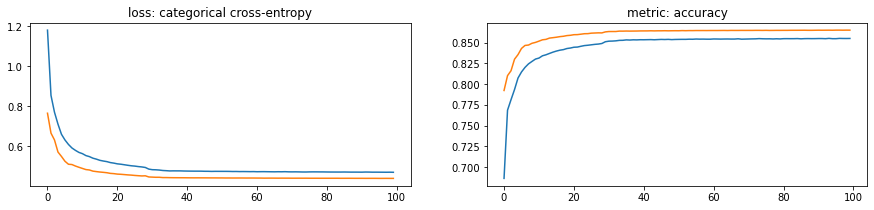

In [36]:
print("Performance on train set:")
model.evaluate(train.batch(sequence_length).batch(batch_size, drop_remainder=True))
print("Performance on valid set:")
model.evaluate(valid.batch(sequence_length).batch(batch_size, drop_remainder=True))
print("Performance on test set:")
model.evaluate(test.batch(sequence_length).batch(batch_size, drop_remainder=True))

plt.figure(figsize=(15,3))

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss: categorical cross-entropy')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('metric: accuracy')

Save the model in the _models_ directory, in a folder with the same _run_id_ used to save the TensorBoard logs.

In [37]:
if not 'models' in listdir(join(getcwd(), 'bach-chorales')):
    mkdir(join(getcwd(), 'bach-chorales', 'models'))

filepath = join(getcwd(), 'bach-chorales', 'models', run_id + '.h5')
model.save(filepath)

### Generating new music

* Save the model in the end of previous section
* Load the model here
* check why aahs are not working on all channels

In [11]:
# music generation

Length = 800 # number of new notes on all voices, actual piece length is Length/4
Temperature = 1.0 # not really temperature (which should be applied before softmax), but works similarly (smaller values are more adventurous, larger values are more conservative)

song = []
song_encoded = one_hot_encoding(-1).reshape((1,1,input_dim)).repeat(16, axis=1)
song_encoded.shape

new_note = -1
new_note_encoding = one_hot_encoding(new_note).reshape((1,1,input_dim))

# music generation loop

for _ in range(Length):
    p = model.predict(song_encoded)[:,-1,:].flatten() # the model is reading the entire chorale up to this point, which makes it very slow for long sequences. This should be improved, providing a limited number os samples for each new note or making the network remember the last state.
    p = p**Temperature / (p**Temperature).sum()
    
    out = np.random.choice(input_dim, p=p)
    new_note_encoding = np.zeros((1,1,input_dim))
    new_note_encoding[0,0,out] = 1
    new_note = one_hot_decoding(new_note_encoding)

    song.append(new_note)
    extended_song = np.zeros((song_encoded.shape[0], song_encoded.shape[1]+1, song_encoded.shape[2]))
    extended_song[:,:-1,:] = song_encoded
    extended_song[:,-1,:] = new_note_encoding
    song_encoded = extended_song

# print chorale as np array    
np.array(song).reshape((-1,4,4))

array([[[65, 60, 57, 53],
        [65, 60, 57, 53],
        [65, 60, 57, 53],
        [65, 60, 57, 53]],

       [[65, 60, 57, 53],
        [65, 60, 57, 53],
        [65, 60, 57, 53],
        [65, 60, 57, 53]],

       [[67, 63, 58, 55],
        [67, 63, 58, 55],
        [67, 62, 58, 55],
        [67, 62, 58, 55]],

       [[67, 62, 58, 55],
        [67, 62, 58, 55],
        [67, 62, 58, 55],
        [67, 62, 58, 55]],

       [[67, 61, 58, 55],
        [67, 61, 58, 55],
        [67, 63, 58, 60],
        [67, 63, 58, 60]],

       [[68, 63, 60, 48],
        [68, 63, 60, 48],
        [68, 63, 60, 48],
        [68, 63, 60, 48]],

       [[68, 65, 53, 49],
        [68, 65, 53, 49],
        [68, 65, 61, 49],
        [68, 65, 61, 49]],

       [[70, 65, 61, 51],
        [70, 65, 61, 51],
        [70, 65, 60, 51],
        [70, 65, 60, 51]],

       [[68, 65, 56, 53],
        [68, 65, 56, 53],
        [68, 63, 60, 56],
        [68, 63, 60, 56]],

       [[68, 65, 61, 58],
        [68, 65, 61,

In [12]:
# clip entries before beginning

first_note_position = 0
for position, note in enumerate(song):
    if note != -1:
        first_note_position = position
        break

new_chorale = np.array(song[first_note_position : -4 + (first_note_position % 4)]).reshape(-1,4)
        
# clip entries after eof

first_eof = (new_chorale.min(axis = 1) == -1).astype('int').argmax()
if first_eof > 0:
    new_chorale = new_chorale[:first_eof, :]
        
# convert finished product to data frame

new_chorale = pd.DataFrame(new_chorale, columns=['note1','note2','note3','note4'])
new_chorale

,note1,note2,note3,note4
0,65,60,57,53
1,65,60,57,53
2,65,60,57,53
3,65,60,57,53
4,65,60,57,53
...,...,...,...,...
83,63,58,55,39
84,63,58,55,39
85,63,58,55,39
86,63,58,55,39


In [13]:
# midi encoding with legato (attack only when new note is different from current one)

new_chorale_midi = mido.MidiFile(type=1)

time_unit = 360
instrument = 52 # choir aahs
volume = [50, 50, 60, 75] # volume for each channel

for channel in range(4):
    track = mido.MidiTrack()
    track.append(mido.Message('program_change', channel = channel, program = instrument, time = 0))
    previous_note = 0
    steps = 1
    
    for pos, note in enumerate(new_chorale.iloc[:, channel]):
        if note == previous_note:
            steps += 1
        if note != previous_note:
            if pos != 0:
                track.append(mido.Message('note_off', channel=channel, note=previous_note, time = steps * time_unit))
            track.append(mido.Message('note_on', channel=channel, note=note, velocity=volume[channel], time=0))
            previous_note = note
            steps = 1
            
    new_chorale_midi.tracks.append(track)
    
filename = 'new_chorale_' + time.strftime("_%Y_%m_%d-%H_%M_%S") + '.mid'
filepath = join(getcwd(), 'bach-chorales', 'new')

new_chorale_midi.save(join(filepath, filename))

### Sandbox

In [14]:
# this class works for training and inference, but does not play nice with model saving.
# code here as backup for the modified version above

#class LN_GRU_Cell(keras.layers.Layer):
#    def __init__(self, units, activation="tanh", dropout=0, recurrent_dropout=0, **kwargs):
#        super().__init__(**kwargs)
#        self.state_size = units
#        self.output_size = units
#        self.GRU_cell = keras.layers.GRUCell(units, dropout=dropout, recurrent_dropout=recurrent_dropout, activation=None)
#        self.layer_norm = keras.layers.LayerNormalization()
#        self.activation = keras.activations.get(activation)
#    def call(self, inputs, states):
#        outputs, new_states = self.GRU_cell(inputs, states)
#        norm_outputs = self.activation(self.layer_norm(outputs))
#        return norm_outputs, [new_states]

In [15]:
# check what are the lowest and hightest notes in the corpus

#files = []
#partition = ['train', 'valid', 'test']

#for p in partition:
#    filename = listdir(join(getcwd(), 'bach-chorales', p))
#    for file in filename:
#        files.append(join(getcwd(), 'bach-chorales', p, file))

#pitch_range = []        

#for file in files:
#    df = pd.read_csv(file)
#    df = df.where(df != 0, other = None)
#    pitch_range.append((df.min().min(), df.max().max()))

#np.array(pitch_range).min(), np.array(pitch_range).max()

In [16]:
# model 1 - .46->.34 @train / .66->.60 @valid / .67->.62 @test
#model = keras.models.Sequential()
#model.add(keras.layers.GRU(input_dim*2, dropout = .1, recurrent_dropout = .1, input_shape = [None, input_dim], return_sequences = True))
#model.add(keras.layers.GRU(input_dim*2, dropout = .1, recurrent_dropout = .1, return_sequences = True))
#model.add(keras.layers.GRU(input_dim*2, dropout = .1, recurrent_dropout = .1, return_sequences = True))
#model.add(keras.layers.Dense(input_dim, kernel_regularizer = keras.regularizers.l2(l2=0)))
#model.add(keras.layers.Dropout(.1))
#model.add(keras.layers.Activation('softmax'))

##### Second learning loop

In [17]:
# Second learning loop

#learning_rate = 0.001 # 0.01 -> 0.001 -> 0.0001
#sequence_length = 256 # 256
#batch_size = 16 # 16 -> 16 -> 64

#optimizer = keras.optimizers.Adam(learning_rate = learning_rate)

#tensorboard_callback = keras.callbacks.TensorBoard(log_dir = log_dir+'_loop_02', histogram_freq = 1)

#model.compile(optimizer=optimizer, loss = 'categorical_crossentropy')

# PROBABLY SHOULDN'T BATCH THE VALIDATION SET! longer sequences tend to provide better prediction...

#history = model.fit(train.batch(sequence_length).batch(batch_size, drop_remainder=True).cache().prefetch(16),
#                    epochs = 1000,
#                    validation_data = valid.batch(sequence_length).batch(batch_size, drop_remainder=True).cache().prefetch(1),
#                    callbacks = [early_stopping, tensorboard_callback])

In [18]:
#model.evaluate(train.batch(sequence_length).batch(batch_size, drop_remainder=True))

In [19]:
#model.evaluate(valid.batch(sequence_length).batch(batch_size, drop_remainder=True))

In [20]:
#model.evaluate(test.batch(sequence_length).batch(batch_size, drop_remainder=True))

In [21]:
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])

In [22]:
# model without layer normalization

#model = keras.models.Sequential(name='model')
#model.add(keras.layers.GRU(2 * input_dim, dropout = gru_dropout, recurrent_dropout = rec_dropout, 
#                           input_shape = [None, input_dim], return_sequences = True, name='GRU1'))
#model.add(keras.layers.GRU(2 * input_dim, dropout = gru_dropout, recurrent_dropout = rec_dropout, 
#                           return_sequences = True, name='GRU2'))
#model.add(keras.layers.GRU(2 * input_dim, dropout = gru_dropout, recurrent_dropout = rec_dropout, 
#                           return_sequences = True, name='GRU3'))
#model.add(keras.layers.Dropout(dense_dropout, name='Dropout1'))
#model.add(keras.layers.Dense(input_dim, activation='softmax', name='Dense1'))

#######################################################################################################